## Download Dataset

In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json
! kaggle datasets download -d andrewmvd/car-plate-detection
! mkdir car-plate-detection
! unzip car-plate-detection.zip -d car-plate-detection

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
 96% 195M/203M [00:05<00:00, 39.6MB/s]
100% 203M/203M [00:05<00:00, 36.3MB/s]
Archive:  car-plate-detection.zip
  inflating: car-plate-detection/annotations/Cars0.xml  
  inflating: car-plate-detection/annotations/Cars1.xml  
  inflating: car-plate-detection/annotations/Cars10.xml  
  inflating: car-plate-detection/annotations/Cars100.xml  
  inflating: car-plate-detection/annotations/Cars101.xml  
  inflating: car-plate-detection/annotations/Cars102.xml  
  inflating: car-plate-detection/annotations/Cars103.xml  
  inflating: car-plate-detection/annotations/Cars104.xml  
  inflating: car-plate-detection/annotations/Cars105.xml  
  inflating: car-plate-detection/annotations/Cars106.xml  
  inflating: car-plate-detection/annotations/Cars107.xml  
  inflating: car-plate-detection/annotations/Cars108.xml  
  inflating: car-plate-detection/annotations/Cars109.xml  
  inflating: car-plate-dete

## Download yolov5 models


In [2]:
!git clone https://github.com/ultralytics/yolov5
%cd yolov5
%pip install -qr requirements.txt

from yolov5 import utils
display = utils.notebook_init()

YOLOv5 🚀 v6.1-266-g34df503 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)


Setup complete ✅ (2 CPUs, 12.7 GB RAM, 39.1/78.2 GB disk)


In [3]:
!echo "train: Dataset/train/images" > data/plate-detection.yaml
!echo "val:   Dataset/val/images" >> data/plate-detection.yaml

!echo "nc: 1" >> data/plate-detection.yaml
!echo "names: ['license']" >> data/plate-detection.yaml

!cat data/plate-detection.yaml

train: Dataset/train/images
val:   Dataset/val/images
nc: 1
names: ['license']


## Prepare Dataset

In [4]:
import os
import numpy as np
from pathlib import Path
from xml.dom.minidom import parse
from shutil import copyfile

In [5]:
FILE_ROOT = "/content/car-plate-detection/"
IMAGE_PATH = FILE_ROOT + "images"  
ANNOTATIONS_PATH = FILE_ROOT + "annotations"

DATA_ROOT = "Dataset/"
DEST_IMAGES_PATH = "train/images"
DEST_LABELS_PATH = "train/labels"

In [6]:
!mkdir -p Dataset/train/labels

In [7]:
# copy images
!cp -rf /content/car-plate-detection/images Dataset/train

In [8]:
!mkdir -p Dataset/val/images
!cp -rf /content/car-plate-detection/images/Cars1*.png Dataset/val/images

In [9]:
def cord_converter(size, box):
    """
    convert xml annotation to darknet format coordinates
    :param size： [w,h]
    :param box: anchor box coordinates [upper-left x,uppler-left y,lower-right x, lower-right y]
    :return: converted [x,y,w,h]
    """
    x1 = int(box[0])
    y1 = int(box[1])
    x2 = int(box[2])
    y2 = int(box[3])

    dw = np.float32(1. / int(size[0]))
    dh = np.float32(1. / int(size[1]))

    w = x2 - x1
    h = y2 - y1
    x = x1 + (w / 2)
    y = y1 + (h / 2)

    x = x * dw
    w = w * dw
    y = y * dh
    h = h * dh
    return [x, y, w, h]
    
def save_file(img_jpg_file_name, size, img_box):
    classes = ['license']
    save_file_name = DATA_ROOT + DEST_LABELS_PATH + '/' + img_jpg_file_name + '.txt'
    print(save_file_name)
    file_path = open(save_file_name, "a+")
    for box in img_box:                  
        #cls_num = classes.index(box[0]) # find class_id
        cls_num = 0
        new_box = cord_converter(size, box[1:]) # convert box coord into YOLO x,y,w,h

        file_path.write(f"{cls_num} {new_box[0]} {new_box[1]} {new_box[2]} {new_box[3]}\n")

    file_path.flush()
    file_path.close()
    
def get_xml_data(file_path, img_xml_file):
    img_path = file_path + '/' + img_xml_file + '.xml'
    print(img_path)

    dom = parse(img_path)
    root = dom.documentElement
    img_name = root.getElementsByTagName("filename")[0].childNodes[0].data
    img_size = root.getElementsByTagName("size")[0]
    objects = root.getElementsByTagName("object")
    img_w = img_size.getElementsByTagName("width")[0].childNodes[0].data
    img_h = img_size.getElementsByTagName("height")[0].childNodes[0].data
    img_c = img_size.getElementsByTagName("depth")[0].childNodes[0].data
    # print("img_name:", img_name)
    # print("image_info:(w,h,c)", img_w, img_h, img_c)
    img_box = []
    for box in objects:
        cls_name = box.getElementsByTagName("name")[0].childNodes[0].data
        x1 = int(box.getElementsByTagName("xmin")[0].childNodes[0].data)
        y1 = int(box.getElementsByTagName("ymin")[0].childNodes[0].data)
        x2 = int(box.getElementsByTagName("xmax")[0].childNodes[0].data)
        y2 = int(box.getElementsByTagName("ymax")[0].childNodes[0].data)
        print("box:(c,xmin,ymin,xmax,ymax)", cls_name, x1, y1, x2, y2)
        img_jpg_file_name = img_xml_file + '.jpg'
        img_box.append([cls_name, x1, y1, x2, y2])
    # print(img_box)
    # test_dataset_box_feature(img_jpg_file_name, img_box)
    save_file(img_xml_file, [img_w, img_h], img_box)

In [10]:
files = os.listdir(ANNOTATIONS_PATH)
for file in files:
    print("file name: ", file)
    file_xml = file.split(".")
    get_xml_data(ANNOTATIONS_PATH, file_xml[0])

file name:  Cars406.xml
/content/car-plate-detection/annotations/Cars406.xml
box:(c,xmin,ymin,xmax,ymax) licence 285 185 374 226
Dataset/train/labels/Cars406.txt
file name:  Cars182.xml
/content/car-plate-detection/annotations/Cars182.xml
box:(c,xmin,ymin,xmax,ymax) licence 168 139 247 159
Dataset/train/labels/Cars182.txt
file name:  Cars62.xml
/content/car-plate-detection/annotations/Cars62.xml
box:(c,xmin,ymin,xmax,ymax) licence 156 110 243 159
Dataset/train/labels/Cars62.txt
file name:  Cars145.xml
/content/car-plate-detection/annotations/Cars145.xml
box:(c,xmin,ymin,xmax,ymax) licence 282 236 422 283
Dataset/train/labels/Cars145.txt
file name:  Cars41.xml
/content/car-plate-detection/annotations/Cars41.xml
box:(c,xmin,ymin,xmax,ymax) licence 109 182 159 206
Dataset/train/labels/Cars41.txt
file name:  Cars126.xml
/content/car-plate-detection/annotations/Cars126.xml
box:(c,xmin,ymin,xmax,ymax) licence 103 99 293 201
Dataset/train/labels/Cars126.txt
file name:  Cars202.xml
/content/ca

In [11]:
!mkdir -p Dataset/val/labels
!cp Dataset/train/labels/Cars1*.txt Dataset/val/labels

## Training YOLO

In [12]:
!python train.py --img 416 --batch 16 --epochs 50 --data data/plate-detection.yaml --cfg models/yolov5m.yaml 

train: weights=yolov5s.pt, cfg=models/yolov5m.yaml, data=data/plate-detection.yaml, hyp=data/hyps/hyp.scratch-low.yaml, epochs=50, batch_size=16, imgsz=416, rect=False, resume=False, nosave=False, noval=False, noautoanchor=False, noplots=False, evolve=None, bucket=, cache=None, image_weights=False, device=, multi_scale=False, single_cls=False, optimizer=SGD, sync_bn=False, workers=8, project=runs/train, name=exp, exist_ok=False, quad=False, cos_lr=False, label_smoothing=0.0, patience=100, freeze=[0], save_period=-1, local_rank=-1, entity=None, upload_dataset=False, bbox_interval=-1, artifact_alias=latest
github: up to date with https://github.com/ultralytics/yolov5 ✅
YOLOv5 🚀 v6.1-266-g34df503 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

hyperparameters: lr0=0.01, lrf=0.01, momentum=0.937, weight_decay=0.0005, warmup_epochs=3.0, warmup_momentum=0.8, warmup_bias_lr=0.1, box=0.05, cls=0.5, cls_pw=1.0, obj=1.0, obj_pw=1.0, iou_t=0.2, anchor_t=4.0, fl_gamma=0.0, hsv_h=0.01

## YOLOv5 Detect

In [13]:
# Download OpenALPR Benchmarks
%cd ..
!git clone https://github.com/openalpr/benchmarks

/content
Cloning into 'benchmarks'...
remote: Enumerating objects: 1752, done.
remote: Total 1752 (delta 0), reused 0 (delta 0), pack-reused 1752
Receiving objects: 100% (1752/1752), 187.98 MiB | 17.55 MiB/s, done.
Resolving deltas: 100% (34/34), done.


In [14]:
%cd yolov5

/content/yolov5


In [15]:
!python detect.py --source ../benchmarks/endtoend/us --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../benchmarks/endtoend/us, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-266-g34df503 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients
image 1/222 /content/benchmarks/endtoend/us/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg: 384x640 1 license, Done. (0.023s)
image 2/222 /content/benchmarks/endtoend/us/12c6cb72-3ea3-49e7-b381-e0cdfc5e8960.jpg: 384x640 Done. (0.022s)
image 3/222 /content/benchmarks/endtoend/us/1e241dc8-8f18-4955-8988-03a0ab49f813.jpg: 384x640 1 license, Done. (0.022s)
image 4/222 /cont

In [16]:
!python detect.py --source ../benchmarks/endtoend/br --conf 0.4 --weights runs/train/exp/weights/best.pt --save-txt

detect: weights=['runs/train/exp/weights/best.pt'], source=../benchmarks/endtoend/br, data=data/coco128.yaml, imgsz=[640, 640], conf_thres=0.4, iou_thres=0.45, max_det=1000, device=, view_img=False, save_txt=True, save_conf=False, save_crop=False, nosave=False, classes=None, agnostic_nms=False, augment=False, visualize=False, update=False, project=runs/detect, name=exp, exist_ok=False, line_thickness=3, hide_labels=False, hide_conf=False, half=False, dnn=False
YOLOv5 🚀 v6.1-266-g34df503 Python-3.7.13 torch-1.11.0+cu113 CUDA:0 (Tesla T4, 15110MiB)

Fusing layers... 
YOLOv5m summary: 290 layers, 20852934 parameters, 0 gradients
image 1/115 /content/benchmarks/endtoend/br/AYO9034.jpg: 384x640 1 license, Done. (0.022s)
image 2/115 /content/benchmarks/endtoend/br/AZJ6991.jpg: 640x640 1 license, Done. (0.029s)
image 3/115 /content/benchmarks/endtoend/br/FZB9581.jpg: 640x640 1 license, Done. (0.029s)
image 4/115 /content/benchmarks/endtoend/br/GWT2180.jpg: 384x640 3 licenses, Done. (0.022s)
i

### Display Detected Images

In [17]:
from IPython.display import Image

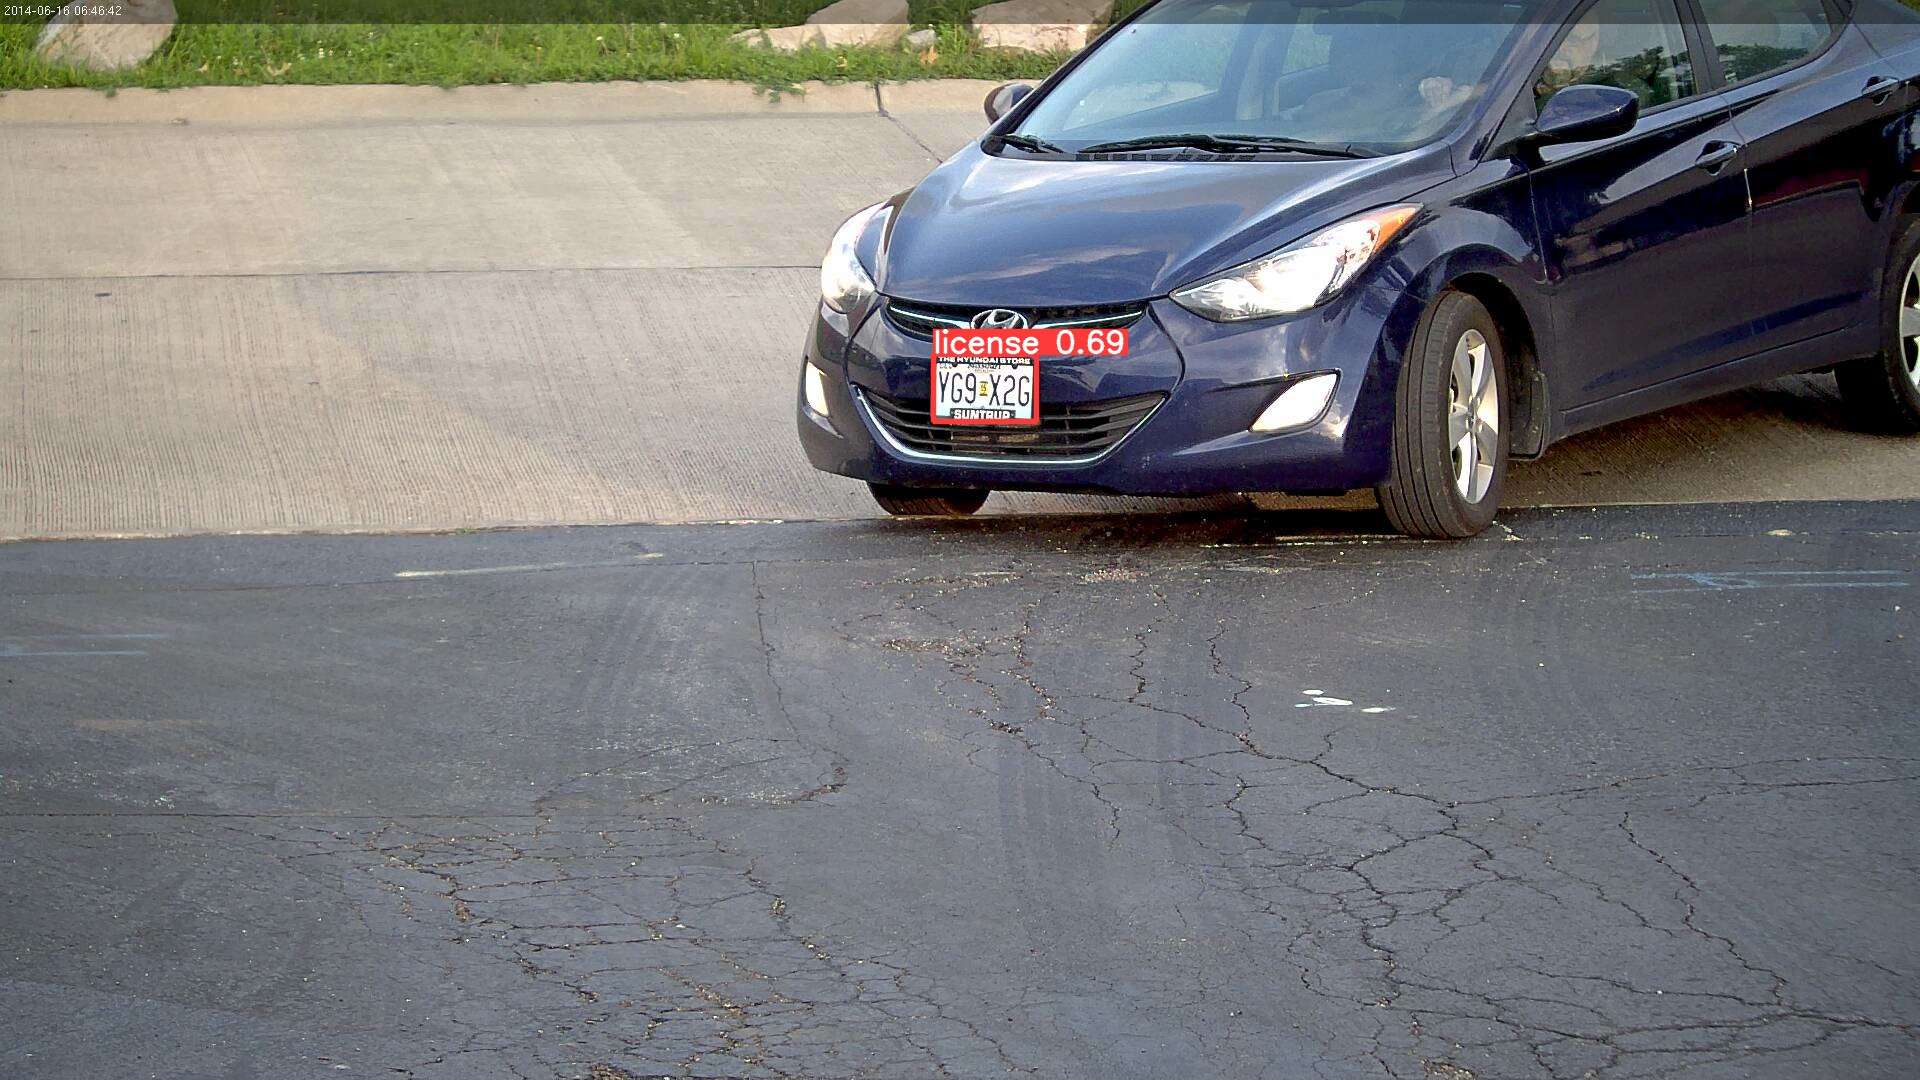

In [22]:
Image('runs/detect/exp2/0b86cecf-67d1-4fc0-87c9-b36b0ee228bb.jpg')

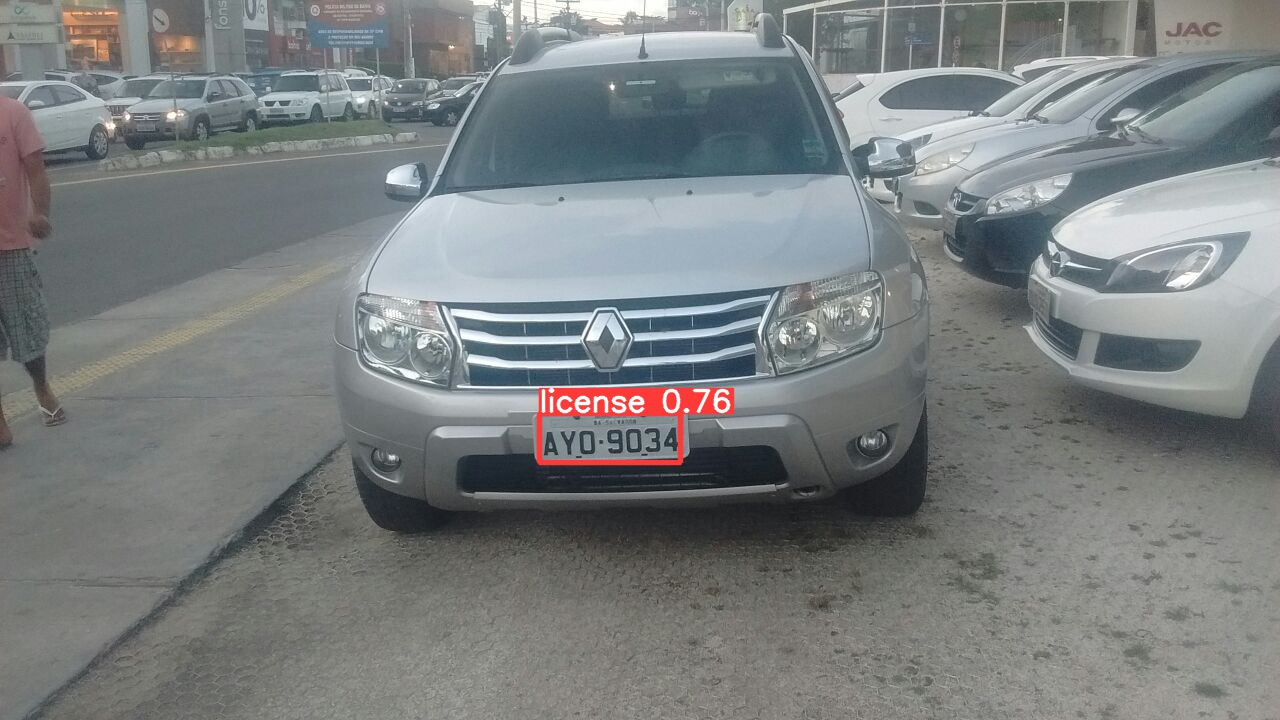

In [26]:
Image('runs/detect/exp2/AYO9034.jpg')